# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


## Package installation

In [1]:
!pip install -q qqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.5 MB/s eta 0:00:00


## Downloading data

!wget https://github.com/MachineLearningHW/HW8_Dataset/releases/download/v1.0.0/data.zip

!unzip data.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [3]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [4]:

train = np.load('/content/drive/MyDrive/ml2022spring-hw8/data/trainingset.npy', allow_pickle=True)
test = np.load('/content/drive/MyDrive/ml2022spring-hw8/data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [5]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [6]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

In [7]:
class Residual_block(nn.Module):
    def __init__(self, ic, oc, stride=1):
        # ic: 输入通道数, oc: 输出通道数, stride: 步长
        super().__init__()
        # 第一个卷积层
        self.conv1 = nn.Sequential(
            # 3×3卷积，stride=2时将(H,W)缩小为(H/2,W/2)
            nn.Conv2d(ic, oc, stride=stride, padding=1, kernel_size=3),
            nn.BatchNorm2d(oc),
            nn.ReLU(inplace=True)  # inplace=True节省内存
        )

        # 第二个卷积层
        self.conv2 = nn.Sequential(
            # 3×3卷积，stride=1保持尺寸不变
            nn.Conv2d(oc, oc, stride=1, padding=1, kernel_size=3),
            nn.BatchNorm2d(oc)
        )

        # 下采样层，用于匹配残差连接的维度
        self.downsample = None
        # 如果步长不为1或输入输出通道数不同，需要下采样
        if((stride != 1)  or (ic != oc)):
            self.downsample = nn.Sequential(
                # 1×1卷积调整维度
                nn.Conv2d(ic, oc, stride=stride, kernel_size=1),
                nn.BatchNorm2d(oc)
            )

    def forward(self, x):
        # 保存输入作为残差
        residual = x
        # 通过两个卷积层
        x = self.conv1(x)
        x = self.conv2(x)

        # 如果需要下采样，调整残差维度
        if(self.downsample != None):
            residual = self.downsample(residual)

        # 残差连接：F(x) + x
        x = x + residual
        # 应用ReLU激活
        x = nn.ReLU(inplace = True)(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block=Residual_block, num_layers = [2, 1, 1, 1]):
        super().__init__()
        # 预处理卷积层：3×64×64 -> 32×64×64
        self.preconv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # 构建残差层的辅助函数
        def make_residual(block, ic, oc, num_layer, stride=1):
            layers = []
            # 第一个块可能改变维度
            layers.append(block(ic, oc, stride))
            # 后续块保持维度不变
            for i in range(num_layer-1):
                layers.append(block(oc, oc))
            return nn.Sequential(*layers)

        # 构建4个残差层，逐步下采样和增加通道数
        # layer0: 32×64×64 -> 64×32×32
        self.layer0 = make_residual(block, ic=32, oc=64, num_layer=num_layers[0], stride=2)
        # layer1: 64×32×32 -> 128×16×16
        self.layer1 = make_residual(block, ic=64, oc=128, num_layer=num_layers[1], stride=2)
        # layer2: 128×16×16 -> 128×8×8
        self.layer2 = make_residual(block, ic=128, oc=128, num_layer=num_layers[2], stride=2)
        # layer3: 128×8×8 -> 64×4×4
        self.layer3 = make_residual(block, ic=128, oc=64, num_layer=num_layers[3], stride=2)

        # 全连接层，将特征图转换为潜在向量
        self.fc = nn.Sequential(
            # 展平：64×4×4 -> 1024
            nn.Flatten(),
            nn.Dropout(0.2),
            # 1024 -> 64维潜在表示
            nn.Linear(64*4*4, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace = True)
        )

        # 解码器，重构图像
        self.decoder = nn.Sequential(
            # 64 -> 64×4×4
            nn.Linear(64, 64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            # 重塑为4D张量：64×4×4 -> (64,4,4)
            nn.Unflatten(1, (64, 4, 4)),
            # 转置卷积逐步上采样
            # (64,4,4) -> (128,8,8)
            nn.ConvTranspose2d(64,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (128,8,8) -> (128,16,16)
            nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (128,16,16) -> (128,32,32)
            nn.ConvTranspose2d(128,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (128,32,32) -> (3,64,64) 重构为原始图像
            nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=1),
            nn.Tanh()  # 输出范围[-1,1]
        )

         # 新增：分类器头
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def encoder(self, x):
        # 编码器前向传播
        x = self.preconv(x)     # (3,64,64) -> (32,64,64)
        x = self.layer0(x)      # -> (64,32,32)
        x = self.layer1(x)      # -> (128,16,16)
        x = self.layer2(x)      # -> (128,8,8)
        x = self.layer3(x)      # -> (64,4,4)
        x = self.fc(x)          # -> (64,)
        return x

    # def forward(self, x):
    #     # 完整的前向传播：编码 + 解码
    #     x = self.encoder(x)
    #     x = self.decoder(x)
    #     return x

    def forward(self, x): # x : (3, 64, 64)
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        anomaly_score = self.classifier(latent)
        return reconstructed, anomaly_score  # 现在返回两个值

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [8]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)

        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])

    def __getitem__(self, index):
        x = self.tensors[index]

        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [9]:
# Training hyperparameters
num_epochs = 100 #50
batch_size = 128 #2000
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'rsn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE(), 'rsn': ResNet()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training loop

In [10]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        # output = model(img)
        # if model_type in ['vae']:
        #     loss = loss_vae(output[0], img, output[1], output[2], criterion)
        # else:
        #     loss = criterion(output, img)
        # 加噪音训练 → 分类器学会看本质 → 测试时更准确判断真正的异常
        # 添加噪声
        noise = torch.randn_like(img) * 0.1  # 10%强度噪声
        img_noisy = torch.clamp(img + noise, -1, 1)  # 限制范围

        if model_type == 'rsn':  # 如果是ResNet
            output, anomaly_pred = model(img_noisy)  # 输入噪声，期望输出干净图像
            recon_loss = criterion(output, img)  # 重构损失
            # 训练数据都是正常的，异常分数应该接近0
            normal_labels = torch.zeros(img.size(0), 1).cuda()
            clf_loss = nn.BCELoss()(anomaly_pred, normal_labels)  # 分类损失
            loss = recon_loss + 0.1 * clf_loss  # 组合损失
        elif model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            output = model(img)
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        # torch.save(model, 'best_model_{}.pt'.format(model_type))
        torch.save(model, f'/content/drive/MyDrive/ml2022spring-hw8/data/best_model_{model_type}.pt')
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    # torch.save(model, 'last_model_{}.pt'.format(model_type))
    torch.save(model, f'/content/drive/MyDrive/ml2022spring-hw8/data/best_model_{model_type}.pt')

 Iters    Elapsed Time      Speed                                               
 0/100          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/100  00:01:45<02:53:40  0.01it/s  1/100  0.1184                              
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/100  00:03:32<02:53:55  0.01it/s  2/100  0.0644                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 3/100  00:05:23<02:54:23  0.01it/s  3/100  0.0572                              
Description   3.0% |█                                                          | Iters    Elapsed Time      Spee

# Inference
Model is loaded and generates its anomaly score predictions.

In [22]:
anomality = list()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        if model_type == 'rsn':
            output, anomaly_pred = model(img)
            recon_error = eval_loss(output, img).sum([1, 2, 3])
            recon_error = torch.sqrt(recon_error)
            clf_score = anomaly_pred.squeeze()
            combined_score = recon_error + clf_score * 2
            anomality.append(combined_score)
        else:
            output = model(img)
            if model_type in ['vae']:
                output = output[0]
            if model_type in ['fcn']:
                loss = eval_loss(output, img).sum(-1)
            else:
                loss = eval_loss(output, img).sum([1, 2, 3])
            anomality.append(torch.sqrt(loss))

anomality = torch.cat(anomality, axis=0)
anomality = anomality.reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label='ID')

## Initialize
- dataloader
- model
- prediction file

In [23]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'/content/drive/MyDrive/ml2022spring-hw8/data/best_model_{model_type}.pt'

try:
    model = torch.load(checkpoint_path, map_location='cuda')
except:
    try:
        model = torch.load(checkpoint_path, map_location='cuda', weights_only=False)
    except:
        model = torch.load(checkpoint_path, map_location='cuda', pickle_module=pickle)

model.eval()

# prediction file
out_file = '/content/drive/MyDrive/ml2022spring-hw8/data/prediction.csv'

### 查看效果

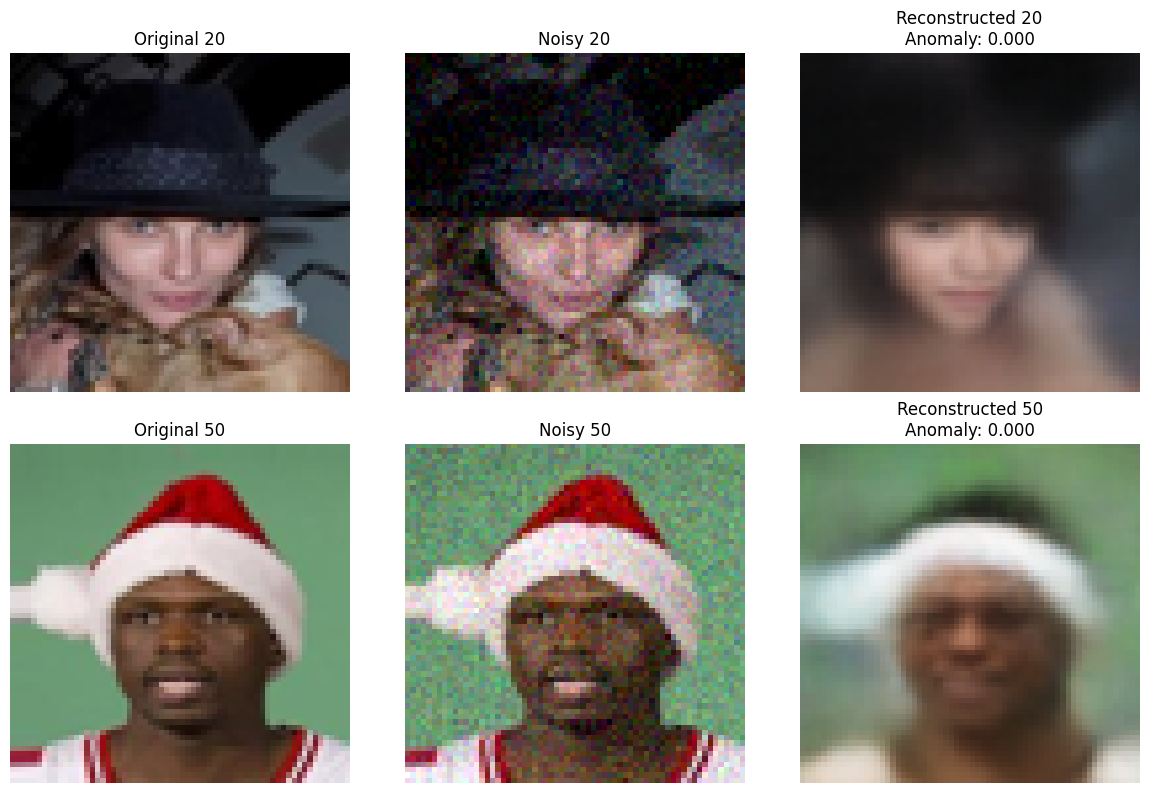

图片 20 - 异常分数: 0.0000
分数说明: 接近0=正常, 接近1=异常


In [24]:
import matplotlib.pyplot as plt

# 选择两张测试图片
sample_indices = [20, 50]  # 可以改成你想看的图片编号

plt.figure(figsize=(12, 8))

for idx, sample_idx in enumerate(sample_indices):
    # 1. 获取原始图片
    sample = test_dataset[sample_idx]
    sample = sample.reshape(1, 3, 64, 64)

    # 2. 添加噪声（模拟训练时的情况）
    noise = torch.randn_like(sample) * 0.1
    sample_noisy = torch.clamp(sample + noise, -1, 1)

    # 3. 模型重构
    model.eval()
    with torch.no_grad():
        img = sample_noisy.cuda()  # 用噪声版本测试

        if model_type == 'rsn':
            output, anomaly_score = model(img)  # 接收两个返回值
            output = output[0]  # 取第一张图片
            anomaly_value = anomaly_score[0].item()  # 异常分数
        else:
            # 原有模型的处理方式
            if model_type in ['fcn']:
                img = img.reshape(img.shape[0], -1)
                output = model(img).reshape(3, 64, 64)
            elif model_type in ['vae']:
                output = model(img)[0][0]
            elif model_type in ['cnn']:
                output = model(img)[0]
            anomaly_value = 0  # 原模型没有异常分数

    # 4. 转换为显示格式的函数
    def tensor_to_img(tensor):
        img_array = tensor.cpu().permute(1, 2, 0).numpy()
        img_array = (img_array + 1) / 2 * 255
        return img_array.astype(np.uint8)

    # 5. 显示三张图：原图、噪声图、重构图
    plt.subplot(2, 3, idx*3 + 1)
    plt.imshow(tensor_to_img(sample[0]))
    plt.title(f'Original {sample_idx}')
    plt.axis('off')

    plt.subplot(2, 3, idx*3 + 2)
    plt.imshow(tensor_to_img(sample_noisy[0]))
    plt.title(f'Noisy {sample_idx}')
    plt.axis('off')

    plt.subplot(2, 3, idx*3 + 3)
    plt.imshow(tensor_to_img(output))
    if model_type == 'rsn':
        plt.title(f'Reconstructed {sample_idx}\nAnomaly: {anomaly_value:.3f}')
    else:
        plt.title(f'Reconstructed {sample_idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 6. 打印重构质量
if model_type == 'rsn':
    print(f"图片 {sample_indices[0]} - 异常分数: {anomaly_value:.4f}")
    print(f"分数说明: 接近0=正常, 接近1=异常")